**Import Libraries**

In [51]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.optimizers import Adam
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from keras.utils import plot_model

**Fetch Data**

In [27]:
# Function to fetch stock data using yfinance
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [28]:
# Function to preprocess data and create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [29]:
# Define the stock and time range
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2023-12-14'

In [30]:
# Fetch stock data
stock_data = get_stock_data(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [31]:
#Display data
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [32]:
#Data Shape
stock_data.shape

(2253, 6)

In [33]:
# Extract closing prices
closing_prices = stock_data['Close'].values.reshape(-1, 1)

**Normalize the dataset using Preprocessing technique MinMax**

In [34]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

**Dataset**

In [35]:
# Define sequence length for LSTM
sequence_length = 10

# Create sequences for LSTM
sequences, targets = create_sequences(closing_prices_scaled, sequence_length)

**Split Dataset**

In [36]:
# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

In [37]:
X_train, y_train = sequences[:split_index], targets[:split_index]
X_test, y_test = sequences[split_index:], targets[split_index:]

**LSTM Model**

In [38]:
# Build LSTM model with dropout and early stopping
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.002), loss='mean_squared_error')

In [39]:
# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 100)           40800     
                                                                 
 dropout_2 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Model Training**

In [40]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

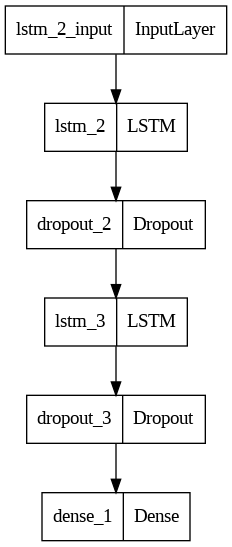

In [53]:
plot_model(model)

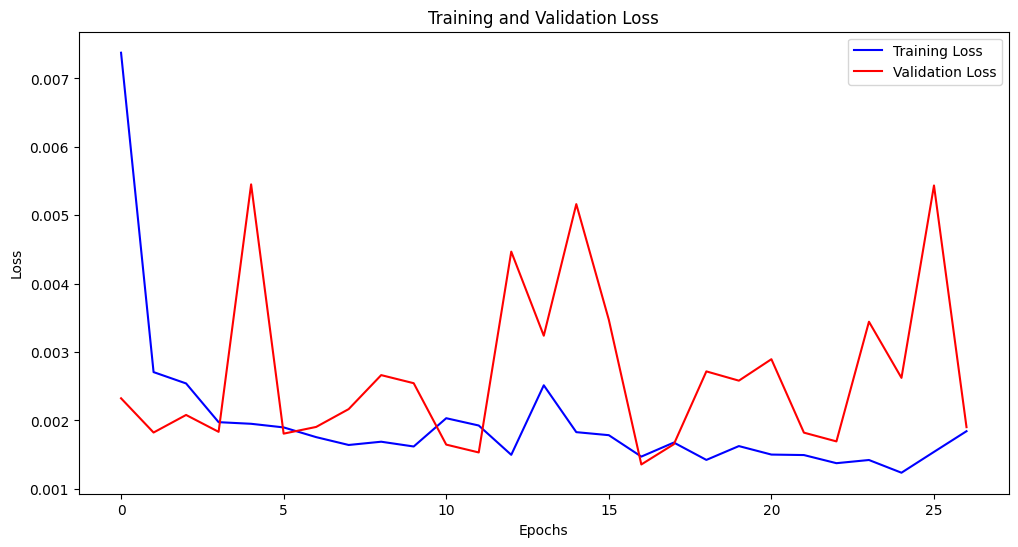

In [42]:
# Plot training and validation loss to check for overfitting
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluate Model**

In [43]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

15/15 [==============================] - 0s 3ms/step - loss: 0.0014
Test Loss: 0.0013565256958827376


**Predictions**

In [44]:
# Make predictions
predictions = model.predict(X_test)

15/15 [==============================] - 1s 3ms/step


In [45]:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

In [46]:
# Denormalize predictions
predictions = scaler.inverse_transform(predictions)


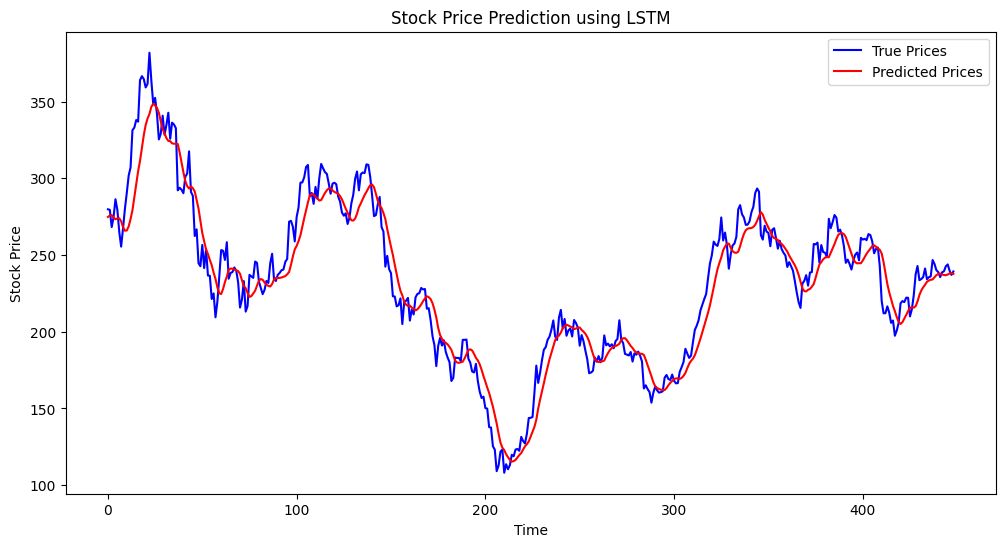

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='True Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [48]:
# Predict stock prices for the test set
y_pred = model.predict(X_test)

# Inverse transform the predicted and true prices
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate R-squared value
r2 = r2_score(y_test_actual, y_pred_actual)
print(f'R-squared: {r2}')

15/15 [==============================] - 0s 3ms/step
R-squared: 0.9213691863656466


**Future Prediction**

1/1 [==============================] - 0s 23ms/step


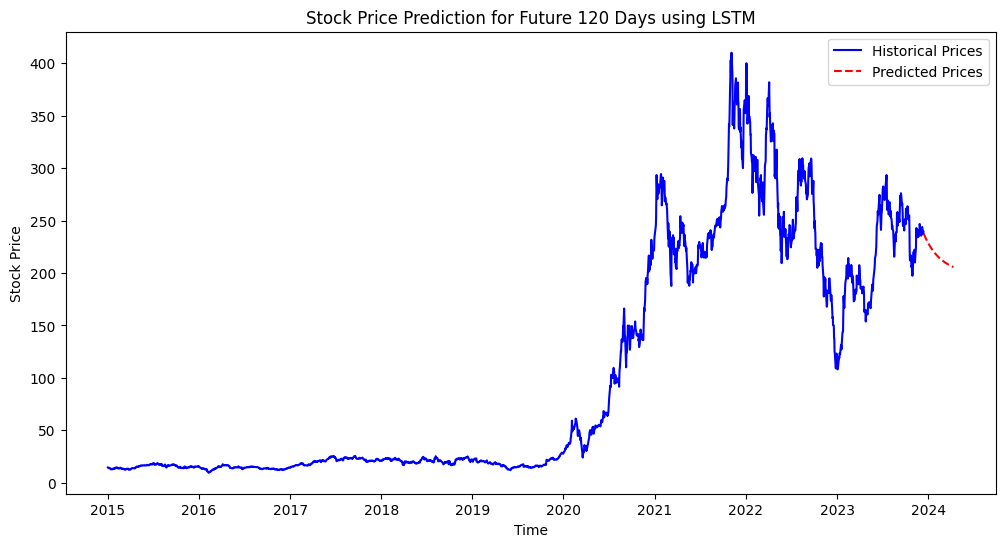

In [49]:
# Number of future days to predict
future_days = 120

# Take the last sequence_length days from the training set to start predicting
last_sequence = closing_prices_scaled[-sequence_length:]

# Create a list to store the predicted prices
predicted_prices = []

# Generate future_days predictions
for _ in range(future_days):
    # Reshape the last sequence to match the model's input shape
    input_sequence = last_sequence.reshape((1, sequence_length, 1))

    # Predict the next day's price
    predicted_price = model.predict(input_sequence)

    # Append the predicted price to the list
    predicted_prices.append(predicted_price[0, 0])

    # Update the last sequence by removing the first element and adding the predicted price
    last_sequence = np.append(last_sequence[1:], predicted_price)

# Denormalize the predicted prices
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Generate future dates for the x-axis
last_date = stock_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_days)

# Plot the true prices and the predicted prices for the future days
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, closing_prices, label='Historical Prices', color='blue')
plt.plot(future_dates, predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Stock Price Prediction for Future 120 Days using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()